In [6]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/SparseCCSA/examples`


In [193]:
using SparseCCSA
using ProfileView
using LinearAlgebra
using SparseArrays
using CairoMakie
using ModelingToolkit
using Optimization
using NLopt
using MathOptInterface
using OptimizationNLopt
using OptimizationMOI

In [396]:
using Random: randperm
using Statistics: mean
using ImplicitAdjoints

n, p = 20, 40
S = 8
α = 0.1
β = 0
G = randn(n, p)
reg = L1(p)
u = zeros(p)
u[randperm(p)[1:S]] .= rand(S)
η = randn(n)

function f(G, α, β, iters)
    y = G * u
    y += 0.05 * mean(abs.(y)) * η
    uest, info = genlasso(G, y, α, β, iters, 1e-12, reg)
end

y = G * u
y += 0.05 * mean(abs.(y)) * η



20-element Vector{Float64}:
  1.0061415068520192
 -0.3607864138029951
  1.0717070084220417
  0.7459998581033361
  0.12117218983610026
  0.9999816136849518
  0.08831424633468278
 -0.8239724298082047
  2.5593357389447795
 -1.2247293734834197
 -0.32287385577697725
  0.35944056604994656
 -1.8972255492332102
  1.8398150016977133
  0.5566546379217127
  0.799002268011056
 -1.6188804100778276
 -0.9876724984201846
  2.790505654640562
 -0.0974226695685502

0.3119055361157575


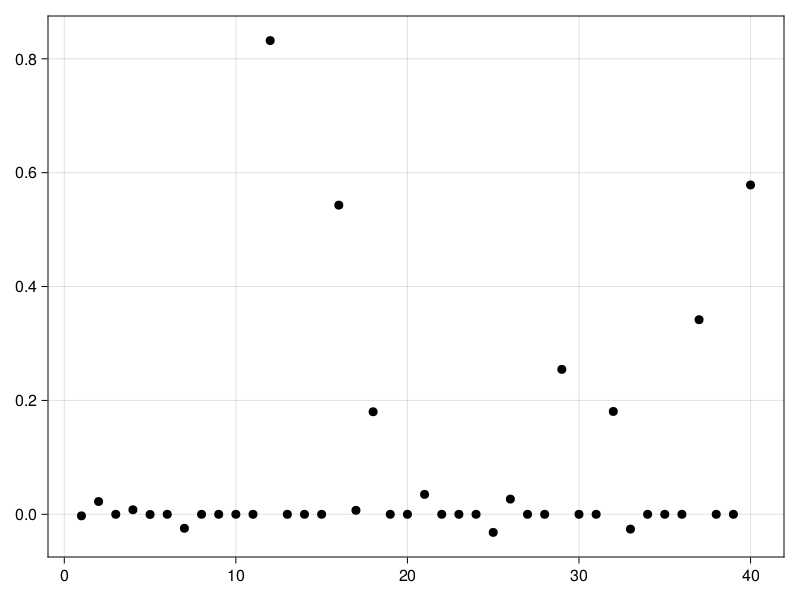

In [400]:
uest, info = f(G, α, β, 2000)
println(sum((G*uest - y).^2) + α * sum(abs.(uest)))
plot(uest)

In [389]:
u0 = rand(p)
t = abs.(u0)
u_and_t = vcat(u0, t)

function obj(u_and_t, _)
    u = u_and_t[1:p]
    t = u_and_t[p+1:2p]
    sum((G * u - y).^2) + α * sum(t)
end

function grad(u_and_t)
    u = u_and_t[1:p]
    t = u_and_t[p+1:2p]
    vcat(2 * G' * (G * u - y), fill(α, p))
end

function inst_grad(res, u_and_t)
    res .= grad(u_and_t)
end
    
function cons(u_and_t, _)
    u = u_and_t[1:p]
    t = u_and_t[p+1:2p]
    vcat(t - u, t + u)
end

func = OptimizationFunction{false}(obj, Optimization.AutoModelingToolkit(false, true); cons=cons, grad=inst_grad, cons_h=false, hess=false, hv=false)


(::OptimizationFunction{false, Optimization.AutoModelingToolkit, typeof(obj), typeof(inst_grad), Bool, Bool, typeof(cons), Nothing, Bool, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}) (generic function with 1 method)

In [401]:
lb = vcat(fill(-Inf, p), zeros(p))
ub = fill(Inf, 2p)
lcons = fill(0., 2p)
ucons = fill(Inf, 2p)

prob = OptimizationProblem(func, u_and_t; lb=lb, ub=ub, lcons=lcons, ucons=ucons)

opt = MathOptInterface.OptimizerWithAttributes(NLopt.Optimizer, "maxeval" => 5000)

MathOptInterface.OptimizerWithAttributes(NLopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("maxeval") => 5000])

  2.676328 seconds (1.57 M allocations: 95.184 MiB, 2.04% gc time)
retcode: ITERATION_LIMIT
u: [-0.010325923012072418, 1.0727814384549975e-11, 8.490972394062842e-11, 9.85871685240749e-13, -1.1177785620445971e-11, 1.4486338978945007e-12, -0.03044549550938577, -0.00039401093996567136, -3.590104980882156e-12, 1.7627256792653406e-11, -1.8741576462890804e-11, 0.8379017581753301, 2.2085343209873488e-11, 0.0009148101453878264, 6.011450234141728e-13, 0.5390884295765569, 1.624545455077612e-11, 0.18783617376674672, 1.1430112427940698e-10, 6.306776281113426e-13, 0.02803619647482895, -0.02213809577537935, 1.5146740424878758e-12, -6.053798328257105e-13, -0.016727929717643298, 0.01127550552202932, 6.902183025197645e-11, -5.2303102317053885e-12, 0.2726791551475253, 0.013171502569222466, 2.3374754360333597e-13, 0.18006993455233083, -0.012154114917427341, 2.1483463989541667e-10, 2.79485251164969e-11, 7.352855100536776e-11, 0.3323464108727043, -3.833064714500427e-12, 9.761105223536147e-12, 0.59859970043

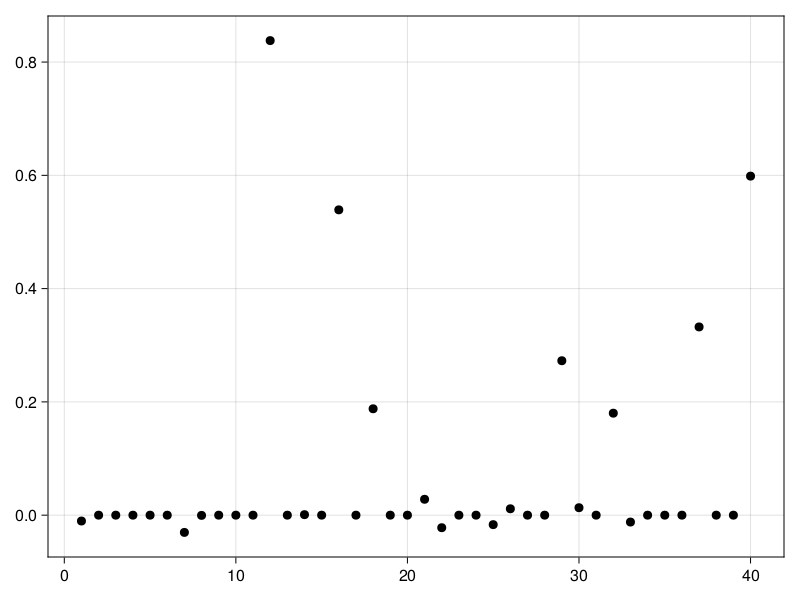

In [402]:
@time sol = solve(prob, opt; algorithm=:LD_CCSAQ)
print(sol)
plot(sol[1:p])

In [4]:
α= 0.1
n= 100
A=sparse(Matrix(SymTridiagonal(2*ones(n),ones(n))))
x_true= ones(n)*10; x_true.= sprand(n,0.1)*10
y=A*x_true


100-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  6.248704339176672
 12.497408678353343
  8.02964468945121
  3.561880700549076
  1.780940350274538
  0.0

In [18]:
I=Vector{Int64}(undef,6n)
J=Vector{Int64}(undef,6n)
V=Vector{Float64}(undef,6n)
for i in 1:2n
    I[i]=1;J[i]=i; V[i]=α;
end
for i in 2n+1:3n
    I[i]=i-(2n-1); J[i]=i-(2n); V[i]=-1;
end
for i in 3n+1:4n
    I[i]=i-(3n-1); J[i]=i-(2n); V[i]=-1;
end
for i in 4n+1:5n
    I[i]=i-(3n-1); J[i]=i-(4n); V[i]=1;
end
for i in 5n+1:6n
    I[i]=i-(4n-1); J[i]=i-(4n); V[i]=-1;
end
∇f=sparse(I,J,V)

201×200 SparseMatrixCSC{Float64, Int64} with 600 stored entries:
⠻⣍⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠫⡍⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄
⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄

In [19]:
function creat_∇f(x)
    ∇f.nzval[1:3:3n-2].=A'*(A*(@view x[1:n])-y)
    return ∇f
end
f=Vector{Float64}(undef,2n+1)
function f_and_∇f(x)
    f = zeros(2n+1)
    f[1]=sum((A*(@view x[1:n])-y).^2)+α*sum(@view x[n+1:2n])
    for i in 1:n
        f[i+1]=-x[i]-x[i+n]
        f[i+n+1]=x[i]-x[i+n]
    end
    return f,creat_∇f(x)
end


f_and_∇f (generic function with 1 method)

In [30]:
max_iters=3
opt = CCSAState(2n, 2n, f_and_∇f,zeros(2n),max_iters=max_iters,xtol_rel=1e-4)
value=Array{Float64}(undef,1000)
recode_xi_stable=Array{Float64}(undef,2n,100)
function cb()
    value[opt.iters]=opt.fx[1]
    println(opt.iters)
    recode_xi_stable[:,opt.iters].=opt.x
end

cb (generic function with 1 method)

In [ ]:
optimize(opt; callback=cb)

1


In [ ]:
@time optimize(opt; callback=cb)


In [36]:
using Optimization

┌ Info: Precompiling Optimization [7f7a1694-90dd-40f0-9382-eb1efda571ba]
└ @ Base loading.jl:1342


In [37]:
OptimizationProblem

OptimizationProblem

In [39]:
OptimizationFunction

OptimizationFunction